# Import Libraries

In [312]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random
import copy
import math
from __future__ import division
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn import tree
import graphviz

import cPickle

import os
from scipy.io import loadmat

In [2]:
#plt.show() in jupyter notebook
%matplotlib inline

# Part 1

#### Analysis Data

In [51]:
def Counts(d):
    '''
    input: a list of lists of strings that represents one new title
    output: a dictionary that contains every word appeared and its count. To be precise, key is word and value is count.
    '''
    wordsCounts = {}
    for i in d:
        temp = []
        for j in i:
            if j in temp:
                continue
            else:
                temp.append(j)
                if j not in wordsCounts:
                    wordsCounts[j] = 1.0
                else:
                    wordsCounts[j] += 1.0

    return wordsCounts

the 1-th most prevealing word in fake news is trump :1282
the 2-th most prevealing word in fake news is to :366
the 3-th most prevealing word in fake news is the :363
the 4-th most prevealing word in fake news is donald :228
the 5-th most prevealing word in fake news is in :218
the 6-th most prevealing word in fake news is of :197
the 7-th most prevealing word in fake news is for :196
the 8-th most prevealing word in fake news is a :172
the 9-th most prevealing word in fake news is and :166
the 10-th most prevealing word in fake news is on :160


the 1-th most prevealing word in real news is trump :1739
the 2-th most prevealing word in real news is donald :828
the 3-th most prevealing word in real news is to :380
the 4-th most prevealing word in real news is us :230
the 5-th most prevealing word in real news is trumps :219
the 6-th most prevealing word in real news is in :213
the 7-th most prevealing word in real news is on :204
the 8-th most prevealing word in real news is of :181
the

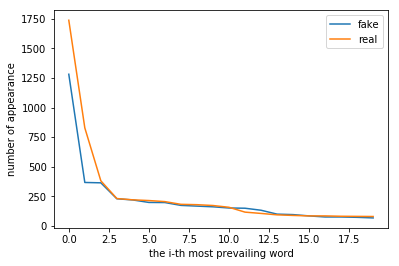

In [52]:
#import fakeData and realData from text files
fakeData = [line.rstrip('\n').split(' ') for line in open('clean_fake.txt')]
realData = [line.rstrip('\n').split(' ') for line in open('clean_real.txt')]

#count words in realData and fakeData
fakeWordsCounts = Counts(fakeData)
realWordsCounts = Counts(realData)
            
#sort words according to how often they appear
fakeWordsInOrder = sorted(fakeWordsCounts, key = fakeWordsCounts.__getitem__, reverse=True)
realWordsInOrder = sorted(realWordsCounts, key = realWordsCounts.__getitem__, reverse=True)

#plot
fig = plt.figure(11)
plt.plot(range(20), [fakeWordsCounts[fakeWordsInOrder[i]] for i in range(20)], label = "fake")
plt.plot(range(20), [realWordsCounts[realWordsInOrder[i]] for i in range(20)], label = "real")
plt.ylabel("number of appearance")
plt.xlabel("the i-th most prevailing word")
plt.legend(loc = "best")

#print the most prevailing words:
for i in range(10):
    print "the %i-th most prevealing word in fake news is %s :%i"%(i+1,fakeWordsInOrder[i],fakeWordsCounts[fakeWordsInOrder[i]])
print('\n')
for i in range(10):
    print "the %i-th most prevealing word in real news is %s :%i"%(i+1,realWordsInOrder[i],realWordsCounts[realWordsInOrder[i]])

#### Spliting data


In [100]:
random.seed(0)
fakeDataCopy = copy.deepcopy(fakeData)
realDataCopy = copy.deepcopy(realData)
random.shuffle(fakeDataCopy)
random.shuffle(realDataCopy)

fakeTrain = fakeDataCopy[:int(len(fakeDataCopy)*0.7)]
fakeVali = fakeDataCopy[int(len(fakeDataCopy)*0.7):int(len(fakeDataCopy)*0.85)]
fakeTest = fakeDataCopy[int(len(fakeDataCopy)*0.85):]

realTrain = realDataCopy[:int(len(realDataCopy)*0.7)]
realVali = realDataCopy[int(len(realDataCopy)*0.7):int(len(realDataCopy)*0.85)]
realTest = realDataCopy[int(len(realDataCopy)*0.85):]

# Part 2

#### Contruct Data and define helper functions

In [104]:
#construct wordList that contains all the words appeared in training sets
wordList = []
for i in fakeTrain:
    wordList.extend(i)
for i in realTrain:
    wordList.extend(i)
wordList = sorted(set(wordList), key=wordList.index)

#Getting parameter:
fakeWordsCountsTrain = Counts(fakeTrain)
realWordsCountsTrain = Counts(realTrain)

In [163]:
def Performance(wordsProb, p_fake, fakeData, realData):
    '''
    input:
        wordsProb: a dictionary whose key is the word xi and value is a list: the first element in sublist is P(xi=1|fake), the second element is sublist is P(xi=1|real).
        fakeData: a list of lists of words, each sublist is a single new. 
        realData: a list of lists of words, each sublist is a single new. 
        p_fake: P(fake)
    output:
        percentage performance on fakeData and real Data
    '''
    correct = 0.0
    for i in fakeData:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb += math.log(p_fake)
        realProb += math.log(1-p_fake)
        
        if fakeProb >= realProb:
            correct += 1

    for i in realData:
        fakeProb = 0.0
        realProb = 0.0
        for j in wordsProb:
            if j in i:
                fakeProb += math.log(wordsProb[j][0])
                realProb += math.log(wordsProb[j][1])
            else:
                fakeProb += math.log(1-wordsProb[j][0])
                realProb += math.log(1-wordsProb[j][1])
        fakeProb += math.log(p_fake)
        realProb += math.log(1-p_fake)

        if fakeProb <= realProb:
            correct += 1        

    perf = float(correct)/float(len(fakeData)+len(realData))
    return perf

In [170]:
def NaiveBayes(m, pHat, ifprint = True, ifreturnProb = False):
    '''
    Given m and pHat, return the performance on Training set, Validation set and Test set.
    '''
    if ifprint:
        print "running NaiveBayes with m = %05.5f, pHat = %05.5f"%(m, pHat)

    wordsProb={} #a dictionary whose key is the word xi and value is a list: the first element in sublist is P(xi=1|fake), the second element is sublist is P(xi=1|real).
    for i in wordList:
        if i in fakeWordsCountsTrain:
            p_x_fake = float(fakeWordsCountsTrain[i] + m*pHat)/float(len(fakeTrain) + m)
        else:
            p_x_fake = float(m*pHat)/float(len(fakeTrain) + m)
        if i in realWordsCountsTrain:
            p_x_real = float(realWordsCountsTrain[i] + m*pHat)/float(len(realTrain) + m)
        else:
            p_x_real = float(m*pHat)/float(len(realTrain) + m)
        wordsProb[i] = [p_x_fake,p_x_real]

    p_fake = float(len(fakeTrain))/float(len(realTrain) + len(fakeTrain)) #P(fake)
    
    perfTrain = Performance(wordsProb, p_fake, fakeTrain, realTrain)
    perfVali = Performance(wordsProb, p_fake, fakeVali, realVali)
    perfTest = Performance(wordsProb, p_fake, fakeTest, realTest)
    
    if ifreturnProb:
        return perfTrain, perfVali, perfTest, wordsProb, p_fake
    else:
        return perfTrain, perfVali, perfTest

#### Tune m and pHat using validation sets

When m = 3.1623, pHat = 0.10000, the performance on validation set is highest:0.88571


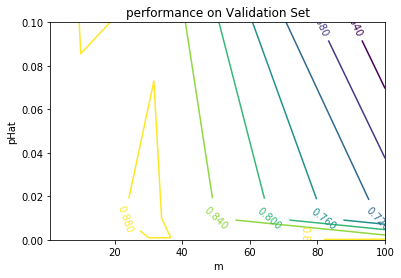

In [155]:
perfValiArray = []
m_ = [10**exp for exp in np.arange(0,2.5,0.5, dtype=float)]
pHat_ = [10**exp for exp in np.arange(-5,0, dtype=float)]
bestPerf = -10000000
for m in m_:
    temp = []
    for pHat in pHat_:
        temp0, temp1, temp2 = NaiveBayes(int(m),pHat,ifprint = False)
        temp.append(temp1)
        if temp1 > bestPerf:
            bestM = m
            bestPHat = pHat
            bestPerf = temp1
    perfValiArray.append(temp)
    
M_,PHat_ = np.meshgrid(m_,pHat_)
ax1 = subplot(111) 
CS = ax1.contour(M_,PHat_,perfValiArray)
plt.clabel(CS, inline=1, fontsize=10)
plt.ylabel("pHat")
plt.xlabel("m")
plt.title("performance on Validation Set")

print "When m = %04.4f, pHat = %05.5f, the performance on validation set is highest:%05.5f"%(bestM, bestPHat,bestPerf)

#### Performance on chosen m and pHat

In [167]:
perfTrain, perfVali, perfTest = NaiveBayes(3.1623, 0.10000, ifprint = False)
print "Performance on Training Set is %05.5f"%perfTrain
print "Performance on Validation Set is %05.5f"%perfVali
print "Performance on Test Set is %05.5f"%perfTest

Performance on Training Set is 0.96193
Performance on Validation Set is 0.88776
Performance on Test Set is 0.84725


# Part 3

### Part 3a

In [188]:
perfTrain, perfVali, perfTest, wordsProb, p_fake = NaiveBayes(3.1623, 0.10000, ifprint = False, ifreturnProb = True)
fakeWordsInProb = {}
realWordsInProb = {}
for i in wordsProb:
    fakeWordsInProb[i] = wordsProb[i][0]
    realWordsInProb[i] = wordsProb[i][1]
fakeWordsInProb = sorted(fakeWordsInProb, key = fakeWordsInProb.__getitem__, reverse=True)
realWordsInProb = sorted(realWordsInProb, key = realWordsInProb.__getitem__, reverse=True)
for i in range(0,10):
    print "the %i-th strongly predicts real news with its presence is %s"%(i+1, realWordsInProb[i])
print "\n"
for i in np.arange(-1,-11,-1):
    print "the %i-th strongly predicts real news with its absence is %s"%(-i, realWordsInProb[i])
print "\n"
for i in range(0,10):
    print "the %i-th strongly predicts fake news with its presence is %s"%(i+1, fakeWordsInProb[i])
print "\n"
for i in np.arange(-1,-11,-1):
    print "the %i-th strongly predicts fake news with its absence is %s"%(-i, fakeWordsInProb[i])

the 1-th strongly predicts real news with its presence is trump
the 2-th strongly predicts real news with its presence is donald
the 3-th strongly predicts real news with its presence is to
the 4-th strongly predicts real news with its presence is us
the 5-th strongly predicts real news with its presence is in
the 6-th strongly predicts real news with its presence is trumps
the 7-th strongly predicts real news with its presence is on
the 8-th strongly predicts real news with its presence is of
the 9-th strongly predicts real news with its presence is says
the 10-th strongly predicts real news with its presence is the


the 1-th strongly predicts real news with its absence is 8th
the 2-th strongly predicts real news with its absence is yell
the 3-th strongly predicts real news with its absence is uneducated
the 4-th strongly predicts real news with its absence is rounding
the 5-th strongly predicts real news with its absence is casual
the 6-th strongly predicts real news with its absenc

### Part 3b

In [192]:


i = 0
index = 0
while i < 10:
    if realWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts real news with its presence is %s"%(i+1, realWordsInProb[index])
        i += 1
    index += 1
print "\n"

i = 0
index = -1
while i < 10:
    if realWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts real news with its absence is %s"%(i+1, realWordsInProb[index])
        i +=1
    index -= 1
print "\n"
        
i = 0
index = 0
while i < 10:
    if fakeWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts fake news with its presence is %s"%(i+1, fakeWordsInProb[index])
        i += 1
    index += 1
print "\n"

i = 0
index = -1
while i < 10:
    if fakeWordsInProb[index] not in ENGLISH_STOP_WORDS:
        print "the %i-th strongly predicts fake news with its absence is %s"%(i+1, fakeWordsInProb[index])
        i +=1
    index -= 1
print "\n"

the 1-th strongly predicts real news with its presence is trump
the 2-th strongly predicts real news with its presence is donald
the 3-th strongly predicts real news with its presence is trumps
the 4-th strongly predicts real news with its presence is says
the 5-th strongly predicts real news with its presence is clinton
the 6-th strongly predicts real news with its presence is election
the 7-th strongly predicts real news with its presence is ban
the 8-th strongly predicts real news with its presence is north
the 9-th strongly predicts real news with its presence is russia
the 10-th strongly predicts real news with its presence is korea


the 1-th strongly predicts real news with its absence is 8th
the 2-th strongly predicts real news with its absence is yell
the 3-th strongly predicts real news with its absence is uneducated
the 4-th strongly predicts real news with its absence is rounding
the 5-th strongly predicts real news with its absence is casual
the 6-th strongly predicts real

### Part 3c

to be conpleted ....

# Part 4

#### Define help functions

In [294]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def f(x, y, theta, lamb):
    x = vstack((ones((1, x.shape[1])), x))
    output = sigmoid(np.dot(theta.T,x))
    return -sum(y*log(output)+(1-y)*log((1-output))) + lamb*np.dot(theta.T,theta)


def df(x, y, theta, lamb):
    x = vstack((ones((1, x.shape[1])), x))
    output = sigmoid(np.dot(theta.T,x))
    return np.dot(x,(output-y).T)+2*lamb*theta


def performance(X, Y, theta):
    X = vstack((np.ones((1, X.shape[1])), X))
    h = dot(theta.T, X)
    cor = 0
    for i in range(Y.shape[1]):
        if Y[0,i] == 1 and h[0,i] > 0:
            cor += 1
        elif Y[0,i] == 0 and h[0,i] < 0:
            cor += 1
    return float(cor) / Y.shape[1]


def grad_descent(f, df, x, y, init_t, alpha, lamb, EPS=1e-5, max_iter=80000, ifpart6 = False):
    prev_t = init_t - 10 * EPS
    t = init_t.copy()
    iter = 0
    perfTrain = []
    perfVali = []
    perfTest = []
    iter_ = []
    while norm(t - prev_t) > EPS and iter < max_iter:
        prev_t = t.copy()
        t -= alpha * df(x, y, t, lamb)
        if iter % 20 == 0:
            iter_.append(iter)
            if ifpart6:
                perfTrain.append(performance(XTrain_part6b,YTrain_part6b,t))
                perfVali.append(performance(XVali_part6b,YVali_part6b,t))
                perfTest.append(performance(XTest_part6b,YTest_part6b,t))
            else:
                perfTrain.append(performance(XTrain,YTrain,t))
                perfVali.append(performance(XVali,YVali,t))
                perfTest.append(performance(XTest,YTest,t))
        if iter % 500 == 0:
            print "Iter", iter
            print "Cost", f(x, y, t, lamb)
            print "Gradient: ", df(x, y, t, lamb), "\n"
        iter += 1
        
    return t, perfTrain, perfVali, perfTest, iter_

def GetDataPart4(Data):
    dim = len(wordList)
    X = np.empty((dim, 0))
    for new in Data:
        temp = np.zeros((dim,1))
        for index, word in enumerate(wordList):
            if word in new:
                temp[index,0] = 1
        X = np.hstack((X, temp))
    return X

def part3(lamb, alpha= 0.00050, st_devi = 0.0001, max_iteration = 5000):
    np.random.seed(0)
    theta0 = np.random.normal(scale=st_devi, size=(len(wordList)+1,1))
    theta, perfTrain, perfVali, perfTest, iter_ = grad_descent(f, df, XTrain, YTrain, theta0, alpha, lamb, max_iter = max_iteration)

    return theta, perfTrain, perfVali, perfTest, iter_

#### contruct data

In [205]:
XTrain = np.hstack((GetDataPart4(fakeTrain), GetDataPart4(realTrain)))
YTrain = np.hstack((np.ones((1,len(fakeTrain))), np.zeros((1,len(realTrain)))))
XVali = np.hstack((GetDataPart4(fakeVali), GetDataPart4(realVali)))
YVali = np.hstack((np.ones((1,len(fakeVali))), np.zeros((1,len(realVali)))))
XTest = np.hstack((GetDataPart4(fakeTest), GetDataPart4(realTest)))
YTest = np.hstack((np.ones((1,len(fakeTest))), np.zeros((1,len(realTest)))))

#### run experiment -- to be completed

In [239]:
theta, perfTrain, perfVali, perfTest, iter_ = part3(0.0001)

Iter 0
Cost [[ 1518.37486803]]
Gradient:  [[ 107.01058261]
 [  -0.55222433]
 [  40.62009568]
 ..., 
 [   0.44482756]
 [   0.44482758]
 [   0.44482758]] 

Iter 500
Cost [[ 562.92057984]]
Gradient:  [[ 1.49394815]
 [-0.27924984]
 [-0.29732871]
 ..., 
 [ 0.04655678]
 [ 0.0465568 ]
 [ 0.0465568 ]] 

Iter 1000
Cost [[ 416.2889773]]
Gradient:  [[ 0.52175889]
 [-0.16544367]
 [ 0.0716807 ]
 ..., 
 [ 0.02150843]
 [ 0.02150845]
 [ 0.02150845]] 

Iter 1500
Cost [[ 334.75812988]]
Gradient:  [[ 0.26357358]
 [-0.12003361]
 [ 0.13686973]
 ..., 
 [ 0.01300703]
 [ 0.01300704]
 [ 0.01300704]] 

Iter 2000
Cost [[ 280.74146058]]
Gradient:  [[ 0.16562993]
 [-0.09567862]
 [ 0.14313695]
 ..., 
 [ 0.00878236]
 [ 0.00878238]
 [ 0.00878238]] 

Iter 2500
Cost [[ 241.87082215]]
Gradient:  [[ 0.11952357]
 [-0.08019129]
 [ 0.13535882]
 ..., 
 [ 0.00631449]
 [ 0.0063145 ]
 [ 0.0063145 ]] 

Iter 3000
Cost [[ 212.44060242]]
Gradient:  [[ 0.09356484]
 [-0.06930255]
 [ 0.12548404]
 ..., 
 [ 0.00473569]
 [ 0.0047357 ]
 [

#### Learning curve plot

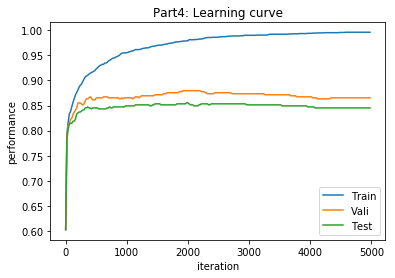

In [246]:
fig = plt.figure(40)
plt.plot(iter_, perfTrain, label = "Train")
plt.plot(iter_, perfVali, label = "Vali")
plt.plot(iter_, perfTest, label = "Test")
plt.ylabel("performance")
plt.xlabel("iteration")
plt.title("Part4: Learning curve")
plt.legend(loc = "best")

# Part 5

to be conpleted ....

# Part 6

### Part 6a

In [250]:
wordTheta = {}
i = 0
for word in wordList:
    wordTheta[word] = theta[i,0]
    i += 1
wordThetaInOrder = sorted(wordTheta, key = wordTheta.__getitem__, reverse=True)
for i in range(10):
    word = wordThetaInOrder[i]
    print "The %i-th most positive theta is %07.7f and the corresponding word is %s"%(i+1, wordTheta[word], word)
print "\n"
for i in np.arange(-1,-11,-1):
    word = wordThetaInOrder[i]
    print "The %i-th most negative theta is %07.7f and the corresponding word is %s"%(-i, wordTheta[word], word)

The 1-th most positive theta is 3.1245011 and the corresponding word is turnout
The 2-th most positive theta is 2.7674193 and the corresponding word is mean
The 3-th most positive theta is 2.5260268 and the corresponding word is hangs
The 4-th most positive theta is 2.4043448 and the corresponding word is tuning
The 5-th most positive theta is 2.3577959 and the corresponding word is between
The 6-th most positive theta is 2.3340223 and the corresponding word is wire
The 7-th most positive theta is 2.3080035 and the corresponding word is protester
The 8-th most positive theta is 2.2702148 and the corresponding word is caught
The 9-th most positive theta is 2.2486076 and the corresponding word is deserved
The 10-th most positive theta is 2.2184715 and the corresponding word is brutal


The 1-th most negative theta is -3.8323850 and the corresponding word is gofundme
The 2-th most negative theta is -2.6217503 and the corresponding word is urged
The 3-th most negative theta is -2.5907552 a

### Part 6b

#### contruct wordList without stop words

In [254]:
wordList_nostop = []
for word in wordList:
    if word not in ENGLISH_STOP_WORDS:
        wordList_nostop.append(word)

#### define helper function

In [298]:
def GetDataPart4_nostop(Data):
    dim = len(wordList_nostop)
    X = np.empty((dim, 0))
    for new in Data:
        temp = np.zeros((dim,1))
        for index, word in enumerate(wordList_nostop):
            if word in new:
                temp[index,0] = 1
        X = np.hstack((X, temp))
    return X

def part6b(lamb, alpha= 0.00050, st_devi = 0.0001, max_iteration = 5000):
    np.random.seed(0)
    theta0 = np.random.normal(scale=st_devi, size=(len(wordList_nostop)+1,1))
    theta_part6b, perfTrain_part6b, perfVali_part6b, perfTest_part6b, iter_ = grad_descent(f, df, XTrain_part6b, YTrain_part6b, theta0, alpha, lamb, max_iter = max_iteration, ifpart6 = True)

    return theta_part6b, perfTrain_part6b, perfVali_part6b, perfTest_part6b, iter_

#### contruct data

In [275]:
XTrain_part6b = np.hstack((GetDataPart4_nostop(fakeTrain), GetDataPart4_nostop(realTrain)))
YTrain_part6b = np.hstack((np.ones((1,len(fakeTrain))), np.zeros((1,len(realTrain)))))
XVali_part6b = np.hstack((GetDataPart4_nostop(fakeVali), GetDataPart4_nostop(realVali)))
YVali_part6b = np.hstack((np.ones((1,len(fakeVali))), np.zeros((1,len(realVali)))))
XTest_part6b = np.hstack((GetDataPart4_nostop(fakeTest), GetDataPart4_nostop(realTest)))
YTest_part6b = np.hstack((np.ones((1,len(fakeTest))), np.zeros((1,len(realTest)))))

#### Run

In [299]:
theta_part6b, perfTrain_part6b, perfVali_part6b, perfTest_part6b, iter_ = part6b(0.0001)

Iter 0
Cost [[ 1525.6619093]]
Gradient:  [[ 104.00618546]
 [  -0.55060046]
 [  37.72066548]
 ..., 
 [   0.44529548]
 [   0.44529546]
 [   0.44529547]] 

Iter 500
Cost [[ 667.03599585]]
Gradient:  [[ 1.03197764]
 [-0.25476676]
 [-0.13387645]
 ..., 
 [ 0.0698076 ]
 [ 0.06980758]
 [ 0.06980759]] 

Iter 1000
Cost [[ 500.25772067]]
Gradient:  [[ 0.37213802]
 [-0.17337138]
 [ 0.05847945]
 ..., 
 [ 0.0351419 ]
 [ 0.03514188]
 [ 0.03514189]] 

Iter 1500
Cost [[ 407.08067144]]
Gradient:  [[ 0.20498467]
 [-0.1383214 ]
 [ 0.06923625]
 ..., 
 [ 0.02242331]
 [ 0.02242329]
 [ 0.0224233 ]] 

Iter 2000
Cost [[ 345.20395592]]
Gradient:  [[ 0.1402082 ]
 [-0.11784076]
 [ 0.05963832]
 ..., 
 [ 0.01582013]
 [ 0.01582011]
 [ 0.01582012]] 

Iter 2500
Cost [[ 300.50523442]]
Gradient:  [[ 0.10687346]
 [-0.10372675]
 [ 0.05026099]
 ..., 
 [ 0.0118333 ]
 [ 0.01183328]
 [ 0.01183329]] 

Iter 3000
Cost [[ 266.47947972]]
Gradient:  [[ 0.08559921]
 [-0.09305096]
 [ 0.044021  ]
 ..., 
 [ 0.00920751]
 [ 0.00920748]
 [

#### Learning curve plot

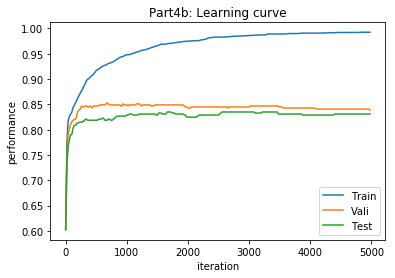

In [300]:
fig = plt.figure(60)
plt.plot(iter_, perfTrain_part6b, label = "Train")
plt.plot(iter_, perfVali_part6b, label = "Vali")
plt.plot(iter_, perfTest_part6b, label = "Test")
plt.ylabel("performance")
plt.xlabel("iteration")
plt.title("Part4b: Learning curve")
plt.legend(loc = "best")

#### Print top 10s

In [301]:
wordTheta_nostop = {}
i = 0
for word in wordList_nostop:
    wordTheta_nostop[word] = theta[i,0]
    i += 1
wordThetaInOrder_nostop = sorted(wordTheta_nostop, key = wordTheta_nostop.__getitem__, reverse=True)
for i in range(10):
    word = wordThetaInOrder_nostop[i]
    print "The %i-th most positive theta is %07.7f and the corresponding word is %s"%(i+1, wordTheta_nostop[word], word)
print "\n"
for i in np.arange(-1,-11,-1):
    word = wordThetaInOrder_nostop[i]
    print "The %i-th most negative theta is %07.7f and the corresponding word is %s"%(-i, wordTheta_nostop[word], word)

The 1-th most positive theta is 3.1245011 and the corresponding word is israeli
The 2-th most positive theta is 2.7674193 and the corresponding word is official
The 3-th most positive theta is 2.5260268 and the corresponding word is hangs
The 4-th most positive theta is 2.4043448 and the corresponding word is light
The 5-th most positive theta is 2.3577959 and the corresponding word is bribery
The 6-th most positive theta is 2.3340223 and the corresponding word is livre
The 7-th most positive theta is 2.3080035 and the corresponding word is million
The 8-th most positive theta is 2.2702148 and the corresponding word is major
The 9-th most positive theta is 2.2486076 and the corresponding word is shocked
The 10-th most positive theta is 2.2184715 and the corresponding word is reveals


The 1-th most negative theta is -3.8323850 and the corresponding word is hits
The 2-th most negative theta is -2.6217503 and the corresponding word is billionaires
The 3-th most negative theta is -2.59075

### Part 6c

to be conpleted ....

# Part 7

### Part 7a

#### contruct data

In [308]:
XTrain_part7 = XTrain.T
YTrain_part7 = YTrain.flatten()
XVali_part7 = XVali.T
YVali_part7 = YVali.flatten()
XTest_part7 = XTest.T
YTest_part7 = YTest.flatten()

#### define helper function

In [309]:
def Performance_part7(X, Y, clf):
    '''
    Take feature X, label Y, and model clf.
    return the percentage performance of model clf on dataset X & Y.
    '''
    predict = clf.predict(X)
    result = 0.0
    for i in range(len(Y)):
        if predict[i] == Y[i]:
            result += 1
    return result/len(predict)

In [314]:
def part7a(max_depth):
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf = clf.fit(XTrain_part7, YTrain_part7)
    perfTrain_part7 = Performance_part7(XTrain_part7, YTrain_part7, clf)
    perfVali_part7 = Performance_part7(XVali_part7, YVali_part7, clf)
    perfTest_part7 = Performance_part7(XTest_part7, YTest_part7, clf)
    return clf, perfTrain_part7, perfVali_part7, perfTest_part7

#### run

In [325]:
perfTrain_part7_ = []
perfVali_part7_ = []
perfTest_part7_ = []
bestPerf = 0
depth_ = [5,10,20,40,70,90,100,150,200,300,500,700,1000]
for depth in depth_:
    clf, perfTrain_part7, perfVali_part7, perfTest_part7 = part7a(depth)
    perfTrain_part7_.append(perfTrain_part7)
    perfVali_part7_.append(perfVali_part7)
    perfTest_part7_.append(perfTest_part7)
    if perfVali_part7 > bestPerf:
        bestPerf = perfVali_part7
        bestDepth = depth
        
print "The model performs best on Validation set with max_depth of %i and performance of %05.5f"%(bestDepth, bestPerf)

The model performs best on Validation set with max_depth of 90 and performance of 0.79184


#### Plot

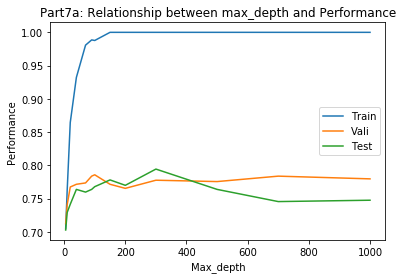

In [323]:
fig = plt.figure(70)
plt.plot(depth_, perfTrain_part7_, label = "Train")
plt.plot(depth_, perfVali_part7_, label = "Vali")
plt.plot(depth_, perfTest_part7_, label = "Test")
plt.ylabel("Performance")
plt.xlabel("Max_depth")
plt.title("Part7a: Relationship between max_depth and Performance")
plt.legend(loc = "best")

### Part 7b

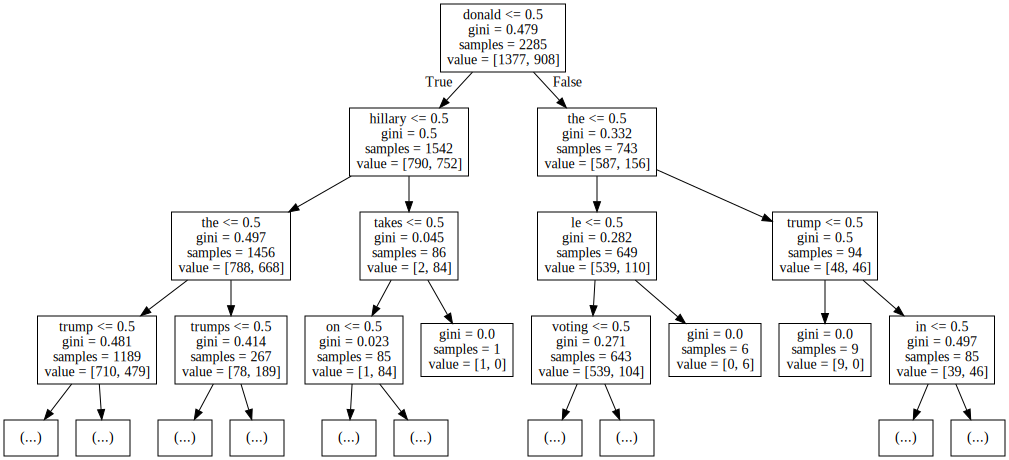

In [329]:
clf, perfTrain_part7, perfVali_part7, perfTest_part7 = part7a(90)
dot_data = tree.export_graphviz(clf, max_depth=3, out_file=None, feature_names = wordList)
graph = graphviz.Source(dot_data)
graph

### Part 7c

to be conpleted ....

# Part 8

### Part 8a

to be conpleted ....

### Part 8b

to be conpleted ....